In [ ]:
import pandas as pd
import os
import sys
from math import sqrt,pow
import networkx as nx
import matplotlib.pyplot as plt
#from GNNfuncs import *

In [3]:
def get_friends(userID : int, df : pd.DataFrame):
    """Returns a list containing the friends of userID in df. df needs columns 'userID', 'friendID' (usually user_friends)."""
    friends = df.loc[df['userID'] == userID]
    return [x for x in friends['friendID']]

def get_tags(userID : int, df: pd.DataFrame):
    """Returns a list containing the tags that userID has assigned to artists in df. df needs columns 'userID', 'tagID' (usually user_taggedartists)."""
    tags = df.loc[df['userID'] == userID]
    return [x for x in tags['tagID']]

def get_artists(userID : int, df : pd.DataFrame):
    """Returns a list containing the artists that userID has listened to in df. df needs columns 'userID', 'artistID' (usually user_artists)."""
    artists = df.loc[df['userID'] == userID]
    return [x for x in artists['artistID']]

def get_df_name(df : pd.DataFrame, globals : dict): # From https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe
    """Returns the name of the input dataframe as a string. Solely used for nice formatting. Requires input of globals() dict."""
    name =[x for x in globals if globals[x] is df][0]
    return name


In [5]:
cwd = os.getcwd()
artists = pd.read_csv(os.path.join(cwd,'data','artists.dat'), delimiter='\t')
tags = pd.read_csv(os.path.join(cwd,'data','tags.dat'), delimiter='\t',encoding='ISO-8859-1')
user_artists = pd.read_csv(os.path.join(cwd,'data','user_artists.dat'), delimiter='\t')
user_friends = pd.read_csv(os.path.join(cwd,'data','user_friends.dat'), delimiter='\t')
user_taggedartists_timestamps = pd.read_csv(os.path.join(cwd,'data','user_taggedartists-timestamps.dat'), delimiter='\t')
user_taggedartists = pd.read_csv(os.path.join(cwd,'data','user_taggedartists.dat'), delimiter='\t')

In [6]:
for dfs in [artists,tags,user_artists,user_friends,user_taggedartists,user_taggedartists_timestamps]:
    print(get_df_name(dfs, globals()),'\n',dfs.isna().sum(),'\n')

artists 
 id              0
name            0
url             0
pictureURL    444
dtype: int64 

tags 
 tagID       0
tagValue    0
dtype: int64 

user_artists 
 userID      0
artistID    0
weight      0
dtype: int64 

user_friends 
 userID      0
friendID    0
dtype: int64 

user_taggedartists 
 userID      0
artistID    0
tagID       0
day         0
month       0
year        0
dtype: int64 

user_taggedartists_timestamps 
 userID       0
artistID     0
tagID        0
timestamp    0
dtype: int64 



In [7]:
colnames = ['id','name']
artists2 = artists[colnames]
artists2.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [8]:
users = user_artists['userID'].unique()
artistcount = [[int(user),len(get_artists(user,user_artists))] for user in users]

not50 = []
for i in range(len(artistcount)):
    if artistcount[i][1] != 50:
        not50.append(artistcount[i])
print(f'There are {len(not50)} users that do not have 50 artist interactions, that is {len(not50)/len(users):6f}% of total users.')
for x in not50:
    print(x)

There are 63 users that do not have 50 artist interactions, that is 0.033298% of total users.
[35, 15]
[38, 49]
[112, 1]
[188, 2]
[192, 30]
[270, 14]
[344, 35]
[374, 4]
[408, 18]
[486, 32]
[493, 33]
[510, 43]
[526, 49]
[542, 7]
[553, 46]
[558, 12]
[613, 34]
[615, 1]
[701, 11]
[712, 38]
[745, 10]
[768, 44]
[769, 33]
[797, 11]
[819, 41]
[845, 28]
[869, 10]
[942, 34]
[995, 38]
[1004, 41]
[1013, 1]
[1014, 25]
[1115, 5]
[1205, 14]
[1262, 21]
[1266, 3]
[1290, 32]
[1307, 1]
[1323, 48]
[1334, 4]
[1397, 14]
[1432, 9]
[1513, 48]
[1543, 27]
[1552, 12]
[1603, 1]
[1611, 4]
[1634, 4]
[1665, 37]
[1675, 13]
[1693, 44]
[1731, 1]
[1744, 15]
[1758, 1]
[1773, 10]
[1799, 43]
[1810, 22]
[1851, 43]
[1859, 37]
[1868, 36]
[1893, 4]
[1939, 40]
[2085, 1]


## Investigating user-user interactions

In [ ]:
# Taken from https://dev.to/josethz00/math-for-devs-cosine-similarity-in-python-2524

def cosine_similarity(vector1: list[float], vector2: list[float]) -> float:
    """Returns the cosine of the angle between two vectors."""
    # the cosine similarity between two vectors is the dot product of the two vectors divided by the magnitude of each vector

    dot_product = 0
    magnitude_vector1 = 0
    magnitude_vector2 = 0

    vector1_length = len(vector1)
    vector2_length = len(vector2)

    if vector1_length > vector2_length:
        # fill vector2 with 0s until it is the same length as vector1 (required for dot product)
        vector2 = vector2 + [0] * (vector1_length - vector2_length)
    elif vector2_length > vector1_length:
        # fill vector1 with 0s until it is the same length as vector2 (required for dot product)
        vector1 = vector1 + [0] * (vector2_length - vector1_length)

    # dot product calculation
    for i in range(len(vector1)):
        dot_product += vector1[i] * vector2[i]

    # vector1 magnitude calculation
    for i in range(len(vector1)):
        magnitude_vector1 += pow(vector1[i], 2)

    # vector2 magnitude calculation
    for i in range(len(vector2)):
        magnitude_vector2 += pow(vector2[i], 2)

    # final magnitude calculation
    magnitude = sqrt(magnitude_vector1) * sqrt(magnitude_vector2)

    # return cosine similarity
    return dot_product / magnitude

In [ ]:
def friends_tag_similarity(userID):
    friends = get_friends(userID,user_friends)
    sims = []
    for friend in friends:
        sims.append(cosine_similarity(get_tags(2,user_taggedartists),get_tags(friend,user_taggedartists)))
    return sum(sims)/len(sims)

In [ ]:
sims2 = []
for userID in user_artists['userID'].unique():
    sims2.append(friends_tag_similarity(userID))
print(sum(sims2)/len(sims2))

0.30130843520311024


# Graph Exploration

use pyspark graphframes tools

In [9]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame
import os

# Define the path to your Python executable
python_path = r'C:\Users\Sheri\AppData\Local\Programs\Python\Python311\python.exe'

# Set the environment variables
os.environ['PYSPARK_PYTHON'] = python_path
os.environ['PYSPARK_DRIVER_PYTHON'] = python_path

# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

In [10]:
if user_artists['userID'][0] != 'user2':
    user_artists['userID'] = 'user' + user_artists['userID'].astype(str) # Place 'user' before each userID 
    user_artists['artistID'] = 'artist' + user_artists['artistID'].astype(str) # Place 'artist' before each artistID
    user_friends['userID'] = 'user' + user_friends['userID'].astype(str) # Place 'user' before each userID
    user_friends['friendID'] = 'user' + user_friends['friendID'].astype(str) # Place 'user' before each userID
    user_taggedartists['artistID'] = 'artist' + user_taggedartists['artistID'].astype(str) # Place 'artist' before each artistID
    user_taggedartists['tagID'] = 'tag' + user_taggedartists['tagID'].astype(str) # Place 'tag' before each tagID
    user_taggedartists['userID'] = 'user' + user_taggedartists['userID'].astype(str) # Place 'user' before each userID
    artists['id'] = 'artist' + artists['id'].astype(str) # Place 'artist' before each artistID
    tags['tagID'] = 'tag' + tags['tagID'].astype(str) # Place 'tag' before each tagID
    print('Designations added')
else:
    print('Designations already present')

Designations added


In [30]:
import pandas as pd

df = user_artists
# Swap the first two columns
df = df[['artistID', 'userID'] + df.columns[2:].tolist()]

In [31]:
# Define vertices
user_vertices = pd.DataFrame(user_artists['userID'].unique(), columns = ['id']) # All users as nodes

artist_vertices = pd.DataFrame(artists['id'].unique(), columns = ["id"]) # all artists as nodes

tag_vertices = pd.DataFrame(tags['tagID'].unique(), columns = ["id"]) # all tags as nodes

# Define edges
user_artist_edges = user_artists.drop('weight', axis = 1).rename(columns = {'userID' : 'src', 'artistID' : 'dst'})
user_artist_edges['type'] = 'listens' # user -> artist edges labelled 'listens'

user_tag_edges = user_taggedartists.rename(columns = {'userID' : 'src', 'tagID' : 'dst'})
for col in ['day','month','year','artistID']:
    user_tag_edges = user_tag_edges.drop(col, axis = 1)
user_tag_edges['type'] = 'tag_used' # user -> tag edges labelled 'tag_used'


artist_tag_edges = user_taggedartists.rename(columns = {'artistID' : 'src', 'tagID' : 'dst'})
for col in ['day','month','year','userID']:
    artist_tag_edges = artist_tag_edges.drop(col, axis = 1)
artist_tag_edges['type'] = 'tagged_as' # artist -> tag edges labelled 'tagged_as'

user_user_edges = user_friends.rename(columns = {'userID' : 'src', 'friendID' : 'dst'})
user_user_edges['type'] = 'friend' # friend <-> friends edges labelled 'friend'

### Bipartite graph

start by only using user and artist nodes, and user-artist interactions

In [106]:
def build_graph(vertex_dfs : list, edge_dfs : list):
    '''Builds a GraphFrame from two lists:
     one containing the vertices datasets, the other containing the edge datasets.
     Lists should contain pandas DataFrames'''
    vertices = spark.createDataFrame(pd.concat([df for df in vertex_dfs]))
    edges = spark.createDataFrame(pd.concat([df for df in edge_dfs]))
    swapped_edges = edges.selectExpr("dst as src", "src as dst", "type")
    bi_edges = edges.union(swapped_edges)
    return GraphFrame(vertices,bi_edges)

def get_all_node_degrees(graph : GraphFrame, path_degree: int):
    '''Gets the degree of all nodes. Path degree input is 1 or 2:
    First degree paths are direct connections from a node to its neighbours.
    Second degree paths are conncections between a node and its neighbour's neighbours.'''
    if path_degree not in [1,2]:
        return 'Degree not in expected range. Should be 1 or 2.', 'Degree not in expected range. Should be 1 or 2.'
    first_degree_paths = graph.find("(a)-[]->(b)")
    if path_degree == 2:
        second_degree_paths = graph.find("(a)-[]->(b); (b)-[]->(c)")
        return first_degree_paths, second_degree_paths
    return first_degree_paths, 'Degree was 1.'

def get_specific_node_degrees(graph : GraphFrame, path_degree: int, node : str):
    '''Gets the degree of a nodes. Path degree input is 1 or 2:
    First degree paths are direct connections from a node to its neighbours.
    Second degree paths are conncections between a node and its neighbour's neighbours.'''
    first, second = get_all_node_degrees(graph, path_degree)
    if first == str:
        return first
    
    first_specific = first.filter(f"a.id == '{node}'").select("a.id","b.id")

    if not isinstance(second, str):
        second_specific = second.filter(f"a.id == '{node}'").select("a.id","c.id")
    else:
        return first_specific, 'Degree was 1.'
    return first_specific, second_specific

In [51]:
graph = build_graph([user_vertices,artist_vertices],[user_artist_edges])

c:\Users\Sheri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [71]:
graph2 = build_graph([user_vertices,artist_vertices,tag_vertices],[user_artist_edges,user_user_edges,user_tag_edges,artist_tag_edges])

c:\Users\Sheri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [110]:
d1,d2 = get_specific_node_degrees(graph,2,'user2')

c:\Users\Sheri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [111]:
d1.show()
d2.show()

+-----+--------+
|   id|      id|
+-----+--------+
|user2|artist70|
|user2|artist95|
|user2|artist81|
|user2|artist82|
|user2|artist83|
|user2|artist87|
|user2|artist85|
|user2|artist86|
|user2|artist62|
|user2|artist52|
|user2|artist55|
|user2|artist64|
|user2|artist97|
|user2|artist79|
|user2|artist53|
|user2|artist94|
|user2|artist91|
|user2|artist76|
|user2|artist57|
|user2|artist61|
+-----+--------+
only showing top 20 rows

+-----+--------+
|   id|      id|
+-----+--------+
|user2|user2078|
|user2|user2047|
|user2|user1982|
|user2|user1947|
|user2|user1946|
|user2|user1922|
|user2|user1920|
|user2|user1918|
|user2|user1910|
|user2|user1885|
|user2|user1832|
|user2|user1785|
|user2|user1708|
|user2|user1691|
|user2|user1669|
|user2|user1641|
|user2|user1635|
|user2|user1604|
|user2|user1597|
|user2|user1587|
+-----+--------+
only showing top 20 rows



In [201]:
d1p = d1.toPandas()
d1p.columns = ['src','dst']
d1p

,src,dst
0,user2,artist70
1,user2,artist95
2,user2,artist81
3,user2,artist82
4,user2,artist83
5,user2,artist87
6,user2,artist85
7,user2,artist86
8,user2,artist62
9,user2,artist52


In [245]:
vertices_pd_users = pd.DataFrame(list(d1p['src'].unique()))
vertices_pd_artists = pd.DataFrame(list(d1p['dst'].unique()))
vertices_pd_users['Partition'] = 0
vertices_pd_artists['Partition'] = 1

vertices_pd = pd.concat([vertices_pd_users,vertices_pd_artists])
vertices_pd.columns = ['id','partition']
edges_pd = d1p
print(vertices_pd,edges_pd)

           id  partition
0       user2          0
0    artist70          1
1    artist95          1
2    artist81          1
3    artist82          1
4    artist83          1
5    artist87          1
6    artist85          1
7    artist86          1
8    artist62          1
9    artist52          1
10   artist55          1
11   artist64          1
12   artist97          1
13   artist79          1
14   artist53          1
15   artist94          1
16   artist91          1
17   artist76          1
18   artist57          1
19   artist61          1
20   artist56          1
21   artist72          1
22   artist78          1
23   artist98          1
24   artist69          1
25   artist89          1
26   artist54          1
27   artist58          1
28   artist73          1
29   artist80          1
30   artist77          1
31   artist93          1
32   artist63          1
33   artist75          1
34   artist90          1
35   artist68          1
36   artist99          1
37   artist59          1


In [251]:
user2_friends = get_friends('user2',user_friends)
user2_friend_edges = pd.DataFrame([('user2',friend) for friend in user2_friends],columns=['src','dst'])
user2_friends.append('user2')

swapped_df = user2_friend_edges[['dst', 'src']].copy()
swapped_df.columns = ['src', 'dst']

user2_friend_edges = pd.concat([user2_friend_edges, swapped_df],ignore_index=True)
user2_friend_edges['relationship'] = 'friends'
edges_pd = user2_friend_edges

artists_list = []

for user in user2_friends:
    lst = get_artists(user,user_artists)
    templist = []
    for artist in lst[:5]:
        artists_list.append(artist)
        templist.append((user,artist,'listens'))
    edges_pd = pd.concat([edges_pd,pd.DataFrame(templist,columns=['src','dst','relationship'])],ignore_index=True)

user2_friends_df = pd.DataFrame(user2_friends,columns=['id'])
user2_friends_df['partition'] = '0'
artists_df = pd.DataFrame(artists_list,columns=['id'])
artists_df['partition'] = '1'

vertices_pd = pd.concat([user2_friends_df,artists_df],ignore_index=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(edges_pd)

         src         dst relationship
0      user2     user275      friends
1      user2     user428      friends
2      user2     user515      friends
3      user2     user761      friends
4      user2     user831      friends
5      user2     user909      friends
6      user2    user1209      friends
7      user2    user1210      friends
8      user2    user1230      friends
9      user2    user1327      friends
10     user2    user1585      friends
11     user2    user1625      friends
12     user2    user1869      friends
13   user275       user2      friends
14   user428       user2      friends
15   user515       user2      friends
16   user761       user2      friends
17   user831       user2      friends
18   user909       user2      friends
19  user1209       user2      friends
20  user1210       user2      friends
21  user1230       user2      friends
22  user1327       user2      friends
23  user1585       user2      friends
24  user1625       user2      friends
25  user1869

2597770949


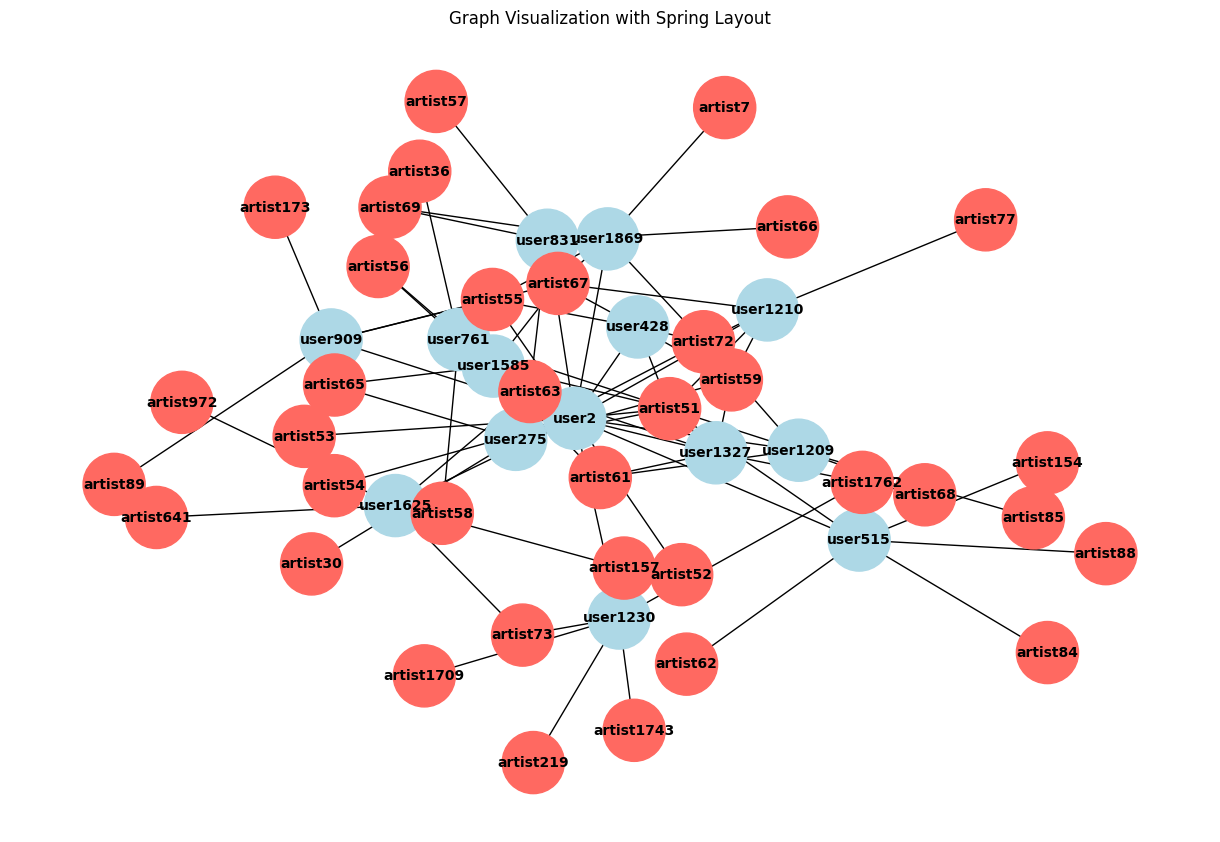

In [ ]:
G = nx.Graph()

# Add nodes with the partition attribute
for index, row in vertices_pd.iterrows():
    G.add_node(row['id'], partition=row['partition'])

# Add edges
for index, row in edges_pd.iterrows():
    G.add_edge(row['src'], row['dst'], relationship=row['relationship'])
# Create the spring layout
pos = nx.spring_layout(G,k=0.5,seed=1533) #3125

# Define the color map based on partitions
color_map = ['lightblue' if G.nodes[node]['partition'] == '0' else '#FF6961' for node in G.nodes()]
# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=color_map, font_weight='bold', font_size=10)
plt.title('Graph Visualization with Spring Layout')
plt.show()


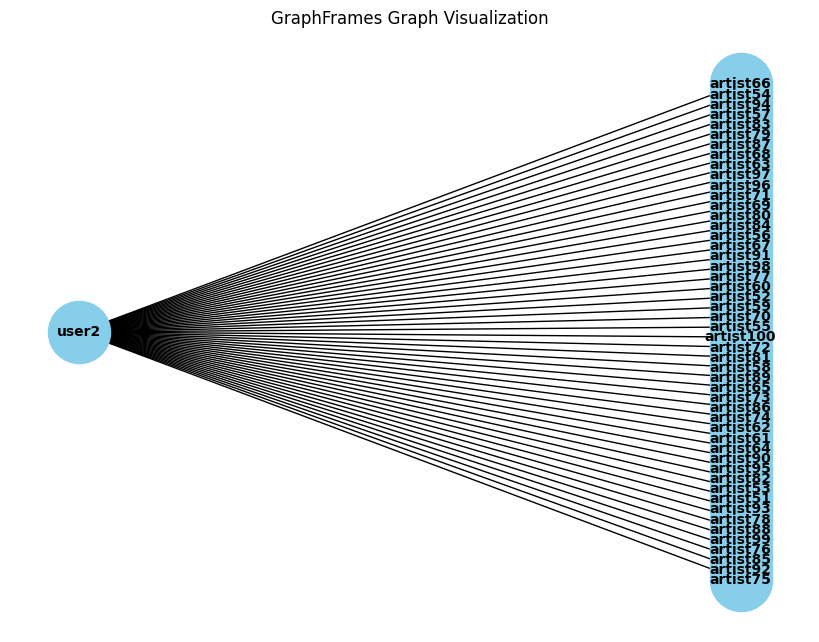

In [246]:
# Create a NetworkX graph from the Pandas DataFrames
G = nx.from_pandas_edgelist(edges_pd, source='src', target='dst',)
for idx, row in vertices_pd.iterrows():
    G.nodes[row['id']].update(row.to_dict())

for n, d in G.nodes(data=True):
    G.nodes[n]['subset'] = d['partition']

# Draw the graph using Matplotlib
plt.figure(figsize=(8, 6))
pos = nx.multipartite_layout(G)  # layout for visualization
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
#nx.draw_networkx_edge_labels(G, pos)
plt.title("GraphFrames Graph Visualization")
plt.show()